In [2]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import click as ck
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import sys
from collections import deque
import time
import logging
from sklearn.metrics import roc_curve, auc, matthews_corrcoef
from scipy.spatial import distance
from scipy import sparse
import math
from utils import FUNC_DICT, Ontology, NAMESPACES
from matplotlib import pyplot as plt


In [3]:

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)



def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):
    # Cross validation evaluation
    # out_file = f'fold{fold}_' + out_file
    # test_data_file = f'fold{fold}_' + test_data_file
    
    hp = Ontology('data/hp.obo', with_rels=True)
    terms_df = pd.read_pickle(terms_file)
    terms_df = terms_df.iloc[:2600,:] 
    terms = terms_df['terms'].values.flatten()
    terms_dict = {v: i for i, v in enumerate(terms)}

    train_df = pd.read_pickle(train_data_file)
    test_df = pd.read_pickle(test_data_file)
    annotations = train_df['hp_annotations'].values
    annotations = list(map(lambda x: set(x), annotations))
    test_annotations = test_df['hp_annotations'].values
    test_annotations = list(map(lambda x: set(x), test_annotations))
    hp.calculate_ic(annotations)

    hp_set = set(terms)
    all_classes = hp.get_term_set(root_class)
    hp_set = hp_set.intersection(all_classes)
    hp_set.discard(root_class)
    print(len(hp_set))
    
    labels = test_annotations
    labels = list(map(lambda x: set(filter(lambda y: y in hp_set, x)), labels))

    # Compute AUC
    auc_terms = list(hp_set)
    auc_terms_dict = {v: i for i, v in enumerate(auc_terms)}
    auc_preds = np.zeros((len(test_df), len(hp_set)), dtype=np.float32)
    auc_labels = np.zeros((len(test_df), len(hp_set)), dtype=np.int32)
    for i, row in enumerate(test_df.itertuples()):
        for j, hp_id in enumerate(auc_terms):
            auc_preds[i, j] = row.preds[terms_dict[hp_id]]
            if hp_id in labels[i]:
                auc_labels[i, j] = 1

    print('auc_labels',auc_labels)
    print('auc_preds',auc_preds)                
                
    roc_auc = compute_roc(auc_labels, auc_preds)
#     roc_auc=0
#     print(roc_auc)
    fmax = 0.0
    tmax = 0.0
    pmax = 0.0
    rmax = 0.0
    precisions = []
    recalls = []
    smin = 1000000.0
    max_preds = None
    for t in range(0, 101):
        threshold = t / 100.0
        preds = []
        for i, row in enumerate(test_df.itertuples()):
            gene_id = row.genes
            annots_dict = {} 
            
            for j, score in enumerate(row.preds):
                hp_id = terms[j]
                # score = score * (1 - alpha)
                if hp_id in annots_dict:
                    annots_dict[hp_id] += score
                else:
                    annots_dict[hp_id] = score
                
            annots = set()
            for hp_id, score in annots_dict.items():
                if score >= threshold:
                    annots.add(hp_id)
            new_annots = set()
            for hp_id in annots:
                new_annots |= hp.get_anchestors(hp_id)
            new_annots = new_annots.intersection(hp_set)
            preds.append(new_annots)
        
    
        # Filter classes
        
        fscore, prec, rec, s = evaluate_annotations(hp, labels, preds)
        precisions.append(prec)
        recalls.append(rec)
        print(f'Fscore: {fscore}, S: {s}, threshold: {threshold}')
        if fmax < fscore:
            fmax = fscore
            tmax = threshold
            max_preds = preds
            pmax = prec
            rmax = rec
        if smin > s:
            smin = s
    test_df['hp_preds'] = max_preds
    test_df.to_pickle(out_file)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUROC: {roc_auc:0.3f}, AUPR: {aupr:0.3f}, Fmax: {fmax:0.3f}, Prec: {pmax:0.3f}, Rec: {rmax:0.3f}, Smin: {smin:0.3f}, threshold: {tmax}')
    plt.figure()
    lw = 2
    plt.plot(recalls, precisions, color='darkorange',
             lw=lw, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="lower right")
    df = pd.DataFrame({'precisions': precisions, 'recalls': recalls})
    # df.to_pickle(f'PR.pkl')

def compute_roc(labels, preds):
    # Compute ROC curve and ROC area for each class

    fpr, tpr, _ = roc_curve(labels.flatten(), preds.flatten())
    roc_auc = auc(fpr, tpr)
    return roc_auc

def compute_mcc(labels, preds):
    # Compute ROC curve and ROC area for each class
    mcc = matthews_corrcoef(labels.flatten(), preds.flatten())
    return mcc

def evaluate_annotations(go, real_annots, pred_annots):
    total = 0
    p = 0.0
    r = 0.0
    p_total= 0
    ru = 0.0
    mi = 0.0
    for i in range(len(real_annots)):
        if len(real_annots[i]) == 0:
            continue
        tp = set(real_annots[i]).intersection(set(pred_annots[i]))
        fp = pred_annots[i] - tp
        fn = real_annots[i] - tp
        for go_id in fp:
            mi += go.get_ic(go_id)
        for go_id in fn:
            ru += go.get_ic(go_id)
        tpn = len(tp)
        fpn = len(fp)
        fnn = len(fn)
        total += 1
        recall = tpn / (1.0 * (tpn + fnn))
        r += recall
        if len(pred_annots[i]) > 0:
            p_total += 1
            precision = tpn / (1.0 * (tpn + fpn))
            p += precision
    print(total)
    if total ==0:
        ru=0
        mi=0
        r=0
    else:
        ru /= total
        mi /= total
        r /= total
    if p_total > 0:
        p /= p_total
    f = 0.0
    if p + r > 0:
        f = 2 * p * r / (p + r)
    s = math.sqrt(ru * ru + mi * mi)
    return f, p, r, s




In [4]:
predictions = pd.read_pickle('data/My_Implementations/Trial_6/predictions.pkl')
predictions


,genes,hp_annotations,go_annotations,iea_annotations,deepgo_annotations,sequences,expressions,preds
2698,284111,"{HP:0030669, HP:0000252, HP:0012447, HP:000252...","{GO:0031974, GO:0008150, GO:0016020, GO:004694...","{GO:0006812, GO:0016020, GO:0015318, GO:005117...","[GO:0003333|0.046, GO:0003674|0.653, GO:000521...",MASALSYVSKFKSFVILFVTPLLLLPLVILMPAKFVRCAYVIILMA...,"[0.018867925, 0.018867925, 0.003144654, 0.0025...","[0.18107338, 0.02637026, 0.118389055, 0.045784..."
3532,7045,"{HP:0007957, HP:0000001, HP:0007809, HP:000070...","{GO:1901564, GO:0044237, GO:0035295, GO:000580...","{GO:1901564, GO:0044237, GO:0005802, GO:001602...","[GO:0001525|0.174, GO:0001568|0.174, GO:000194...",MALFVRLLALALALALGPAATLAGPAKSPYQLVLQHSRLRGRQHGP...,"[0.0024600246, 0.0012300123, 0.007380074, 0.00...","[0.18971097, 0.03077107, 0.1339755, 0.04706163..."
58,8289,"{HP:0011363, HP:0030669, HP:0000252, HP:000181...","{GO:0080090, GO:0044237, GO:0071824, GO:000815...","{GO:0010629, GO:0044237, GO:0080090, GO:007182...","[GO:0000003|0.224, GO:0000075|0.011, GO:000007...",MAAQVAPAAASSLGNPPPPPPSELKKAEQQQREEAGGEAAAAAAAE...,"[0.2, 0.23076923, 0.24615385, 1.0, 0.41538462,...","[0.3248115, 0.07466784, 0.24291627, 0.08477556..."
3689,7355,"{HP:0030669, HP:0000252, HP:0012447, HP:000252...","{GO:0031974, GO:0008150, GO:0016020, GO:000588...","{GO:0031974, GO:0031301, GO:0008150, GO:001602...","[GO:0000139|0.385, GO:0003674|0.645, GO:000521...",MAAVGAGGSTAAPGPGAVSAGALEPGTASAAHRRLKYISLAVLVVQ...,"[0.22580644, 0.29032257, 0.29032257, 0.6774193...","[0.24511163, 0.0513752, 0.19016874, 0.06535278..."
2,8195,"{HP:0030669, HP:0000426, HP:0003202, HP:010062...","{GO:0051640, GO:0048199, GO:0016020, GO:005117...","{GO:0032231, GO:0051649, GO:0120025, GO:000693...","[GO:0000003|0.595, GO:0000226|0.861, GO:000110...",MSRLEAKKPSLCKSEPLTTERVRTTLSVLKRIVTSCYGPSGRLKQL...,"[0.5, 0.71428573, 0.39285713, 0.4642857, 0.428...","[0.18911086, 0.03039152, 0.13264742, 0.0469942..."
208,353,"{HP:0000001, HP:0000077, HP:0003110, HP:001221...","{GO:1901564, GO:0044237, GO:0016020, GO:004310...","{GO:1901564, GO:0090407, GO:0044237, GO:006000...","[GO:0000166|0.285, GO:0000287|0.041, GO:000177...",MADSELQLVEQRIRSFPDFPTPGVVFRDISPVLKDPASFRAAIGLL...,"[0.11235955, 0.11797753, 0.15730338, 1.0, 0.60...","[0.20130499, 0.035671685, 0.14899684, 0.050627..."
3883,57167,"{HP:0045009, HP:0030241, HP:0025487, HP:000054...","{GO:0031974, GO:0008150, GO:0043226, GO:004442...","{GO:0010629, GO:0044237, GO:0080090, GO:000636...","[GO:0000003|0.072, GO:0000118|0.046, GO:000012...",MSRRKQAKPQHINSEEDQGEQQPQQQTPEFADAAPAAPAAGELGAP...,"[0.009090909, 0.009090909, 0.018181818, 0.0, 0...","[0.3254277, 0.0749235, 0.24334604, 0.08511339,..."
2647,30009,"{HP:0002715, HP:0000433, HP:0010978, HP:000000...","{GO:0010629, GO:0044237, GO:0080090, GO:001647...","{GO:0044237, GO:0016477, GO:0016064, GO:000244...","[GO:0000003|0.073, GO:0000018|0.065, GO:000012...",MGIVEPGCGDMLTGTEPMPGSDEGRAPGADPQHRYFYPEPGAQDAD...,"[0.0043478264, 0.0043478264, 0.02173913, 0.782...","[0.19202015, 0.031995155, 0.13772193, 0.047824..."
938,1644,"{HP:0000152, HP:0001263, HP:0011024, HP:000071...","{GO:1901564, GO:0044237, GO:0006576, GO:000815...","{GO:1901564, GO:0044237, GO:0035690, GO:001602...","[GO:0000096|0.006, GO:0000098|0.006, GO:000030...",MNASEFRRRGKEMVDYMANYMEGIEGRQVYPDVEPGYLRPLIPAAA...,"[0.0021739132, 0.0021739132, 0.0021739132, 0.0...","[0.16785428, 0.021639755, 0.10198748, 0.041072..."
251,254394,"{HP:0000001, HP:0000002, HP:0004323, HP:000081...","{GO:0044237, GO:0051179, GO:0051641, GO:000815...","{GO:0044237, GO:0019953, GO:0051179, GO:005164...","[GO:0000003|0.151, GO:0000082|0.047, GO:000022...",MNSDQVTLVGQVFESYVSEYHKNDILLILKERDEDAHYPVVVNAMT...,"[0.12857142, 0.14285715, 0.2857143, 0.5714286,...","[0.21391587, 0.04027295, 0.16187114, 0.0548314..."


# Trail_6 --> 39-11-2021 3.00AM CNN only

2600
auc_labels [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
auc_preds [[0.0036781  0.00050102 0.03180255 ... 0.00807712 0.00181421 0.02141989]
 [0.00191101 0.00059564 0.02943542 ... 0.00329694 0.00574975 0.02333296]
 [0.00498964 0.00754886 0.11052607 ... 0.00651366 0.04003842 0.03629114]
 ...
 [0.00473931 0.00039605 0.02670869 ... 0.04237954 0.00078433 0.00983953]
 [0.00409578 0.00463991 0.08929551 ... 0.0054229  0.0211986  0.03211206]
 [0.00296204 0.00120001 0.04716791 ... 0.00425851 0.00678479 0.02660936]]
348
Fscore: 0.032299174035396, S: 6198.995870292973, threshold: 0.0
348
Fscore: 0.04882046235051616, S: 3510.5154987740025, threshold: 0.01
348
Fscore: 0.05825898574771254, S: 2740.124461647572, threshold: 0.02
348
Fscore: 0.06658985571064774, S: 2262.29737304676, threshold: 0.03
348
Fscore: 0.07408623574196237, S: 1929.6646669224515, threshold: 0.04
348
Fscore: 0.07987007792819947, S: 1691.2377472342912, t

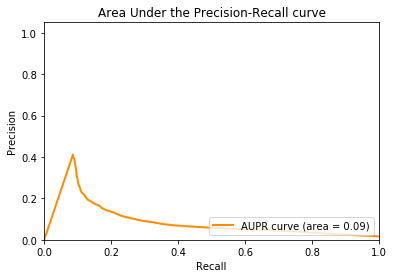

In [9]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_6/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/predictions_organs.pkl',
     
     'HP:0000001',
     
     1)

7
auc_labels [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
auc_preds [[0.55935776 0.10014442 0.14017226 ... 0.04018191 0.19209206 0.9013977 ]
 [0.49802265 0.11283679 0.15507013 ... 0.06126128 0.20887914 0.87852895]
 [0.773193   0.33745077 0.28524995 ... 0.16511309 0.2520368  0.87100524]
 ...
 [0.5327481  0.2012232  0.11291562 ... 0.04080382 0.10665175 0.7418623 ]
 [0.76906085 0.2885111  0.26344013 ... 0.12702572 0.22892313 0.8814288 ]
 [0.65809447 0.17026787 0.19491072 ... 0.07390104 0.20967278 0.891749  ]]
41
Fscore: 0.4528301886792454, S: 12.29910860110177, threshold: 0.0
41
Fscore: 0.4528301886792454, S: 12.29910860110177, threshold: 0.01
41
Fscore: 0.42549828636076287, S: 12.198508442841026, threshold: 0.02
41
Fscore: 0.3975948181553453, S: 12.055821470423577, threshold: 0.03
41
Fscore: 0.37844629319401474, S: 11.920894214824795, threshold: 0.04
41
Fscore: 0.37201984751300987, S: 11.784625202106566, threshold

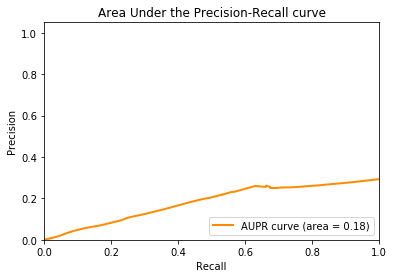

In [10]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_6/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/predictions_max_Onset.pkl',
     
     'HP:0000004',
     
     1)

In [11]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_6/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/predictions_max_inheritance.pkl',
     
     'HP:0000005',
     
     1)

0
auc_labels []
auc_preds []


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

# Trial_7_12-8-2021 12:58PM but on 40% from the dataset=testset

12
auc_labels [[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
auc_preds [[0.01409847 0.03926036 0.03633764 ... 0.4083653  0.00190607 0.5833077 ]
 [0.01409841 0.03926033 0.03633755 ... 0.40836528 0.00190604 0.58330774]
 [0.01409841 0.03926033 0.03633749 ... 0.40836525 0.00190604 0.58330774]
 ...
 [0.01409841 0.03926033 0.03633755 ... 0.40836528 0.00190607 0.58330774]
 [0.01409841 0.03926033 0.03633749 ... 0.40836528 0.00190604 0.58330774]
 [0.01409841 0.03926033 0.03633755 ... 0.40836528 0.00190604 0.58330774]]
369
Fscore: 0.2127144298688195, S: 26.574102167667633, threshold: 0.0
369
Fscore: 0.26940138822534976, S: 16.200959313497844, threshold: 0.01
369
Fscore: 0.29431264217016695, S: 14.737481004007277, threshold: 0.02
369
Fscore: 0.360257350836667, S: 7.758840429382796, threshold: 0.03
369
Fscore: 0.4568801247676716, S: 4.3622057633427245, threshold: 0.04
369
Fscore: 0.4568801247676716, S: 4.3622057633427245, thr

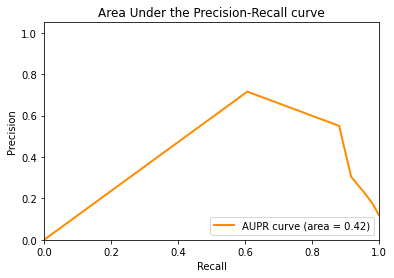

In [4]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions_40_perc.pkl',
     
     'data/all_terms.pkl',
     
     'data/My_Implementations/Trial_7/predictions_max_inheritance_40_perc.pkl',
     
     'HP:0000005',
     
     1)



3
auc_labels [[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
auc_preds [[0.02784541 0.06706777 0.08406371]
 [0.02784538 0.06706771 0.08406362]
 [0.02784532 0.06706762 0.08406359]
 ...
 [0.02784538 0.06706771 0.08406359]
 [0.02784532 0.06706765 0.08406359]
 [0.02784538 0.06706765 0.08406359]]
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.0
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.01
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.02
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.03
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.04
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.05
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.06
41
Fscore: 0.659400544959128, S: 1.020773522689825, threshold: 0.07
41
Fscore: 0.659400544959128, S: 1.020773522689825, threshold: 0.08
41
Fscore: 0.0, S: 1.7152287479097845, threshold: 0.09
41
Fscore: 0.0, S: 1.

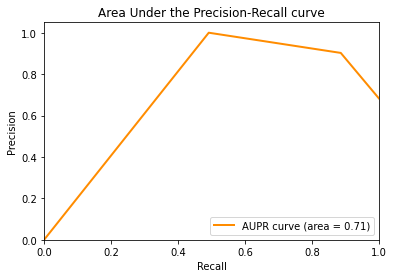

In [5]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions_40_perc.pkl',
     
     'data/all_terms.pkl',
     
     'data/My_Implementations/Trial_7/predictions_max_Onset_40_perc.pkl',
     
     'HP:0000004',
     
     1)

2600
auc_labels [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
auc_preds [[0.0041534  0.03803185 0.07091963 ... 0.01030982 0.0019452  0.019521  ]
 [0.0041534  0.03803176 0.07091957 ... 0.01030976 0.0019452  0.01952097]
 [0.00415343 0.03803176 0.07091951 ... 0.01030979 0.00194526 0.01952097]
 ...
 [0.0041534  0.03803176 0.07091957 ... 0.01030976 0.0019452  0.01952097]
 [0.0041534  0.03803176 0.07091951 ... 0.01030979 0.00194526 0.01952097]
 [0.0041534  0.03803176 0.07091957 ... 0.01030976 0.0019452  0.01952097]]
348
Fscore: 0.032299174035396, S: 6198.995870292955, threshold: 0.0
348
Fscore: 0.04233004119082743, S: 4324.366678603809, threshold: 0.01
348
Fscore: 0.049615423958033915, S: 3447.252838674614, threshold: 0.02
348
Fscore: 0.057759416598021175, S: 2804.1673931982477, threshold: 0.03
348
Fscore: 0.06513769466445171, S: 2301.5970352394843, threshold: 0.04
348
Fscore: 0.07045876645850767, S: 1989.674986247902,

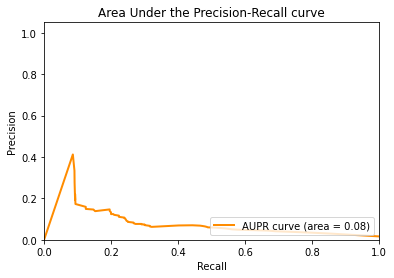

In [6]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):
main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions_40_perc.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/Trial_7/predictions_organs_40_perc.pkl',
     
     'HP:0000001',
     
     1)

# Trail_7 --> 28-11-2021 8.00 PM CNN+LSTM

12
auc_labels [[0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
auc_preds [[0.58330774 0.02824565 0.03926034 ... 0.0535521  0.40836525 0.0040911 ]
 [0.58330774 0.02824571 0.03926041 ... 0.05355221 0.40836534 0.00409112]
 [0.58330774 0.02824566 0.03926035 ... 0.0535521  0.40836525 0.0040911 ]
 ...
 [0.58330774 0.02824566 0.03926034 ... 0.05355212 0.40836525 0.00409111]
 [0.58330774 0.02824564 0.03926034 ... 0.0535521  0.40836525 0.0040911 ]
 [0.58330774 0.02824566 0.03926034 ... 0.05355212 0.40836525 0.0040911 ]]
370
Fscore: 0.2132796780684106, S: 26.56746305830702, threshold: 0.0
370
Fscore: 0.27011733149627176, S: 16.19404092858482, threshold: 0.01
370
Fscore: 0.2951031886434015, S: 14.730484871377726, threshold: 0.02
370
Fscore: 0.3612566947831249, S: 7.751288010429911, threshold: 0.03
370
Fscore: 0.4573924346653296, S: 4.356499471471902, threshold: 0.04
370
Fscore: 0.4573924346653296, S: 4.356499471471902, thresho

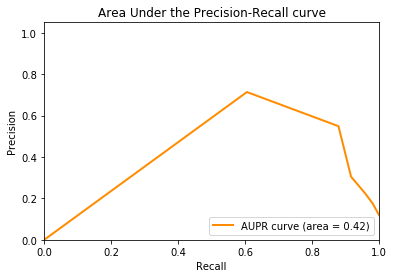

In [16]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions.pkl',
     
     'data/all_terms.pkl',
     
     'data/My_Implementations/Trial_7/predictions_max_inheritance.pkl',
     
     'HP:0000005',
     
     1)



3
auc_labels [[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
auc_preds [[0.06706767 0.08406361 0.02784537]
 [0.06706776 0.08406372 0.02784543]
 [0.06706768 0.08406363 0.02784538]
 ...
 [0.06706767 0.08406365 0.02784538]
 [0.06706767 0.08406361 0.02784537]
 [0.06706767 0.08406363 0.02784538]]
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.0
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.01
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.02
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.03
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.04
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.05
41
Fscore: 0.8942350332594236, S: 0.3839319760799547, threshold: 0.06
41
Fscore: 0.659400544959128, S: 1.020773522689825, threshold: 0.07
41
Fscore: 0.659400544959128, S: 1.020773522689825, threshold: 0.08
41
Fscore: 0.0, S: 1.7152287479097845, threshold: 0.09
41
Fscore: 0.0, S: 1.

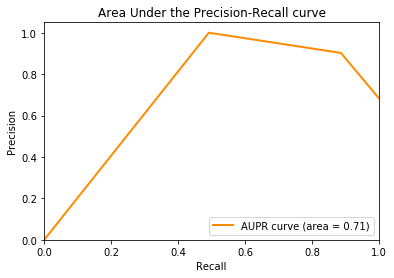

In [17]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions.pkl',
     
     'data/all_terms.pkl',
     
     'data/My_Implementations/Trial_7/predictions_max_Onset.pkl',
     
     'HP:0000004',
     
     1)

2600
auc_labels [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
auc_preds [[0.00436296 0.00515576 0.00675631 ... 0.00883329 0.0682475  0.03311892]
 [0.00436298 0.00515577 0.00675633 ... 0.00883331 0.06824759 0.03311899]
 [0.00436297 0.00515576 0.00675632 ... 0.00883329 0.06824752 0.03311894]
 ...
 [0.00436297 0.00515576 0.00675632 ... 0.00883329 0.0682475  0.03311892]
 [0.00436296 0.00515575 0.00675631 ... 0.00883329 0.0682475  0.0331189 ]
 [0.00436297 0.00515576 0.00675632 ... 0.00883329 0.0682475  0.03311892]]
349
Fscore: 0.03229132670708051, S: 6199.031446696278, threshold: 0.0
349
Fscore: 0.04232615487018659, S: 4324.3904128308695, threshold: 0.01
349
Fscore: 0.0496174813341731, S: 3447.2679077049575, threshold: 0.02
349
Fscore: 0.057770364614082526, S: 2804.1740695020817, threshold: 0.03
349
Fscore: 0.06515637890414509, S: 2301.5981876038436, threshold: 0.04
349
Fscore: 0.07049114201931789, S: 1989.66835142447

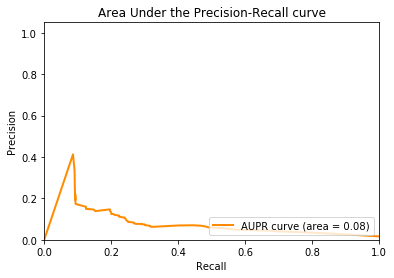

In [18]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/predictions_organs.pkl',
     
     'HP:0000001',
     
     1)

2600
auc_labels [[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
auc_preds [[0.01783666 0.16641742 0.10372799 ... 0.0535521  0.01028989 0.06359018]
 [0.01783669 0.16641755 0.10372812 ... 0.05355221 0.01028992 0.06359027]
 [0.01783666 0.16641743 0.103728   ... 0.0535521  0.01028989 0.06359018]
 ...
 [0.01783666 0.16641742 0.103728   ... 0.05355212 0.0102899  0.06359018]
 [0.01783665 0.16641738 0.10372797 ... 0.0535521  0.01028989 0.06359015]
 [0.01783666 0.16641742 0.103728   ... 0.05355212 0.0102899  0.06359018]]
349
Fscore: 0.03229132670708051, S: 6199.031446696285, threshold: 0.0
349
Fscore: 0.04232615487018659, S: 4324.390412830872, threshold: 0.01
349
Fscore: 0.0496174813341731, S: 3447.267907704965, threshold: 0.02
349
Fscore: 0.057770364614082526, S: 2804.1740695020835, threshold: 0.03
349
Fscore: 0.06515637890414509, S: 2301.5981876038422, threshold: 0.04
349
Fscore: 0.07049114201931789, S: 1989.6683514244753

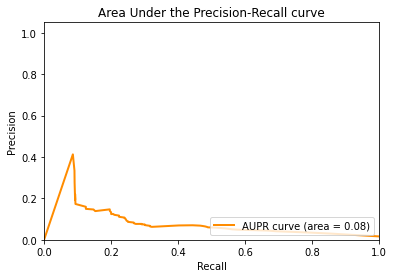

In [5]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_7/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/predictions_organs.pkl',
     
     'HP:0000001',
     
     1)

8693
0.709358954003989
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.0
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.01
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.02
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.03
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.04
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.05
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.06
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.07
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.08
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.09
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.1
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.11
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.12
Fscore: 0.03264505474780109, S: 26751.89853300126, threshold: 0.13
Fscore: 0.03264505474780109, S: 26751.898

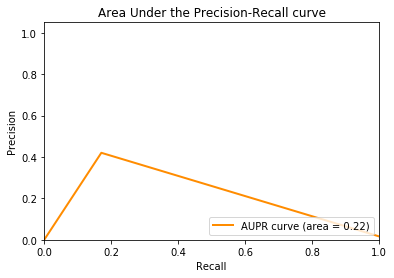

In [4]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_1/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/predictions_max.pkl',
     
     'HP:0000001',
     
     1)

2600
0.9208884920995606
Fscore: 0.03229132670708051, S: 8098.290192262669, threshold: 0.0
Fscore: 0.13221249627063114, S: 783.4056930387608, threshold: 0.01
Fscore: 0.1786692576662703, S: 428.3260038928548, threshold: 0.02
Fscore: 0.21535044874496723, S: 283.9827041090693, threshold: 0.03
Fscore: 0.2546813080127853, S: 198.99297606382532, threshold: 0.04
Fscore: 0.2793863211595651, S: 150.50183041682257, threshold: 0.05
Fscore: 0.31712509141523065, S: 105.34630863346258, threshold: 0.06
Fscore: 0.3400958720152564, S: 82.64433168670513, threshold: 0.07
Fscore: 0.36068776232840444, S: 69.35671563506672, threshold: 0.08
Fscore: 0.3682023998880328, S: 61.39393776013848, threshold: 0.09
Fscore: 0.37759835090483695, S: 53.96576757157827, threshold: 0.1
Fscore: 0.3799705092762636, S: 51.90644196164182, threshold: 0.11
Fscore: 0.39493486299241, S: 48.94993281100303, threshold: 0.12
Fscore: 0.39571576846093803, S: 48.33187285463306, threshold: 0.13
Fscore: 0.4018164148409951, S: 46.578665691795

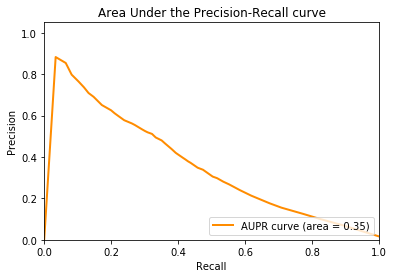

In [6]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_3/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/Trial_3/predictions_max.pkl',
     
     'HP:0000001',
     
     1)

2600
0.9268221964679213
Fscore: 0.03229132670708051, S: 8098.290192262669, threshold: 0.0
Fscore: 0.15168256425206292, S: 680.9964479861469, threshold: 0.01
Fscore: 0.206844034963141, S: 377.5919946637953, threshold: 0.02
Fscore: 0.2483933725339777, S: 252.4182875481237, threshold: 0.03
Fscore: 0.28116036449613135, S: 186.17024062998647, threshold: 0.04
Fscore: 0.3120702118242537, S: 142.08204197900497, threshold: 0.05
Fscore: 0.33827546417033477, S: 113.67746182772268, threshold: 0.06
Fscore: 0.35988559452867597, S: 93.62810968181905, threshold: 0.07
Fscore: 0.37599465111527147, S: 79.79302354284346, threshold: 0.08
Fscore: 0.3853300137147864, S: 70.29274952239466, threshold: 0.09
Fscore: 0.393329987941591, S: 63.88436866680813, threshold: 0.1
Fscore: 0.39875567735606887, S: 59.03478601490866, threshold: 0.11
Fscore: 0.40383013427368136, S: 55.11830465624359, threshold: 0.12
Fscore: 0.40927613754087666, S: 52.082661703779976, threshold: 0.13
Fscore: 0.4135352660012302, S: 50.136685791

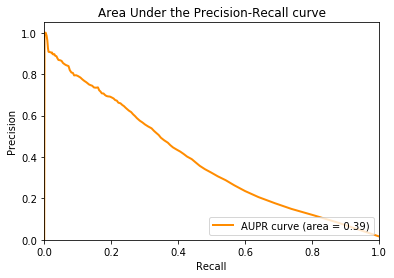

In [7]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_4/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/Trial_4/predictions_max.pkl',
     
     'HP:0000001',
     
     1)

2600
0.9319369700317081
Fscore: 0.03229132670708051, S: 8098.29019226267, threshold: 0.0
Fscore: 0.17363816015294764, S: 583.0365879232837, threshold: 0.01
Fscore: 0.2354498896749006, S: 320.1015159836168, threshold: 0.02
Fscore: 0.2794377587188274, S: 215.40719002075886, threshold: 0.03
Fscore: 0.31505732196152175, S: 159.6579794593961, threshold: 0.04
Fscore: 0.3408889992556348, S: 125.81672384664702, threshold: 0.05
Fscore: 0.36242466691913655, S: 103.00064384300146, threshold: 0.06
Fscore: 0.38035352347058954, S: 87.13475666921957, threshold: 0.07
Fscore: 0.3943370195914846, S: 75.29991363984372, threshold: 0.08
Fscore: 0.4043320415644002, S: 66.30434589886511, threshold: 0.09
Fscore: 0.41007348666371096, S: 60.2618721755271, threshold: 0.1
Fscore: 0.4131533944122926, S: 55.979825369308, threshold: 0.11
Fscore: 0.4189134593457349, S: 52.49258033802567, threshold: 0.12
Fscore: 0.42414241071540976, S: 49.913057756861704, threshold: 0.13
Fscore: 0.4278102360514039, S: 48.2947383786250

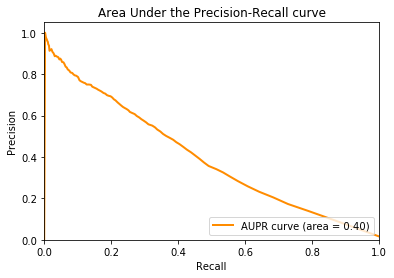

In [3]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_5/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/Trial_5/predictions_max.pkl',
     
     'HP:0000001',
     
     1)

In [12]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_5/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/Trial_5/predictions_inhert.pkl',
     
     'HP:0000005',
     
     1)

0
auc_labels []
auc_preds []


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

7
auc_labels [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
auc_preds [[2.1828929e-04 5.7496533e-02 2.3906343e-02 ... 4.8403099e-02
  6.1059929e-04 2.4038306e-04]
 [1.4922231e-04 5.5091482e-02 1.3828016e-02 ... 5.2647293e-02
  4.0465681e-04 1.3982195e-04]
 [9.5938973e-05 3.8581163e-02 1.6241729e-02 ... 2.9150993e-02
  3.0907031e-04 8.8811030e-05]
 ...
 [3.9911797e-04 4.3643143e-02 1.5677646e-02 ... 3.9588917e-02
  4.5653540e-04 4.4281219e-04]
 [3.3728447e-04 8.5866518e-02 4.0126212e-02 ... 7.0956618e-02
  1.2754920e-03 4.8774783e-04]
 [1.3044450e-04 7.4912161e-02 3.2229003e-02 ... 5.5404890e-02
  7.0864079e-04 1.4858991e-04]]
41
Fscore: 0.4528301886792454, S: 12.29910860110177, threshold: 0.0
41
Fscore: 0.811594202898551, S: 1.240502410457198, threshold: 0.01
41
Fscore: 0.8671582529778787, S: 0.6984549982296889, threshold: 0.02
41
Fscore: 0.8814394365141807, S: 0.4965969449704727, threshold: 0.03
41
Fscore: 0.8355

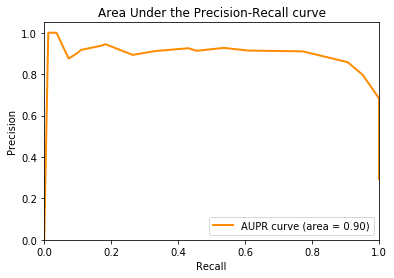

In [13]:
# def main(train_data_file, test_data_file, terms_file, out_file, root_class, fold):



main(  'data/My_Implementations/human.pkl',
     
      'data/My_Implementations/Trial_5/predictions.pkl',
     
     'data/My_Implementations/terms.pkl',
     
     'data/My_Implementations/Trial_5/predictions_onset.pkl',
     
     'HP:0000004',
     
     1)